# Diving into Diamond Data: Analysis of the Diamond Market

## 1. 0: Imports

##### Import needed packages

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.cluster import Birch
from sklearn.cluster import KMeans

##### Load the DiamondData file into a dataframe

In [149]:
data = pd.read_csv('DiamondData.csv')
print('Original Data Shape: ', data.shape)

Original Data Shape:  (50000, 10)


## 2. 0: Cleaning the Data

### 2.1: General Cleaning

##### Remove all leading and trailing spaces in the data

In [150]:
data.columns = data.columns.str.strip()

##### Check if there are duplicate rows in the data. If so, remove them.

In [151]:
dups = data.duplicated()

if dups.sum() == 0:
    print('There are no duplicates')
    
else:
    print('The number of duplicate rows: ', dups.sum())
    data = data.drop_duplicates()
    print('The duplicates have been dropped \n')
    print('New Data Shape: ', data.shape)

The number of duplicate rows:  115
The duplicates have been dropped 

New Data Shape:  (49885, 10)


##### Print the number of missing values for each attribute in the dataset

In [152]:
print('Number of Instances = %d\nNumber of Attributes = %d' % (data.shape[0], data.shape[1]))
print('------------------------------')
print('Number of Missing Values ')
data.isnull().sum()

Number of Instances = 49885
Number of Attributes = 10
------------------------------
Number of Missing Values 


carat        0
cut          0
color        0
clarity      0
depth      471
table      390
price      253
x          221
y          333
z          428
dtype: int64

##### Drop any rows with a null value

Since there is a small number of rows with missing values, we will drop any rows with a null value. There will still be a large data set to run analysis.

In [153]:
data = data.dropna(axis = 'rows', subset = ['price', 'depth', 'table', 'x', 'y', 'z'])
print('New Data Shape: ', data.shape)
data.isnull().sum()

New Data Shape:  (47825, 10)


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

##### Find the typos and categories of the non-numeric attributes

In [154]:
print('Breakdown of the Non-Numeric 4 Cs')
print('\n', data.groupby('color').size())
print('\n', data.groupby('cut').size())
print('\n', data.groupby('clarity').size())

Breakdown of the Non-Numeric 4 Cs

 color
D     5975
E     8700
F     8438
G    10035
H     7361
I     4830
J     2486
dtype: int64

 cut
Fair          1408
Good          4351
Ideal        19091
Premium      12242
Very Geod     2153
Very Good     8580
dtype: int64

 clarity
I1        654
IF       1590
SI1     11583
SI2      8105
VS1      7230
VS2     10932
VVS1     3243
VVS2     4488
dtype: int64


##### Replace the typo values with real values

In [155]:
data = data.replace('Very Geod', 'Very Good')
data.groupby('cut').size()

cut
Fair          1408
Good          4351
Ideal        19091
Premium      12242
Very Good    10733
dtype: int64

##### Place non-numeric attributes on a numeric scale

Since cut, color, and clarity are ordinal, we can numerically place each value on a scale. 0 will indicate the lowest quality for each attribute. <br>
We will use a scale of: <br>
Color: 0 - 6 (0 = J and 6 = D) <br>
Cut: 0 - 4 (0 - Fair and 4 = Ideal) <br>
Clarity: 0 - 7 (0 = I1 and 7 = IF)

In [156]:
#color
data = data.replace('D', 6)
data = data.replace('E', 5)
data = data.replace('F', 4)
data = data.replace('G', 3)
data = data.replace('H', 2)
data = data.replace('I', 1)
data = data.replace('J', 0)

#cut
data = data.replace('Ideal', 4)
data = data.replace('Premium', 3)
data = data.replace('Very Good', 2)
data = data.replace('Good', 1)
data = data.replace('Fair', 0)

#clarity
data = data.replace('IF', 7)
data = data.replace('VVS1', 6)
data = data.replace('VVS2', 5)
data = data.replace('VS1', 4)
data = data.replace('VS2', 3)
data = data.replace('SI1', 2)
data = data.replace('SI2', 1)
data = data.replace('I1', 0)

### 2.2: Discover outliers and eliminate them

##### Histogram of numerical values

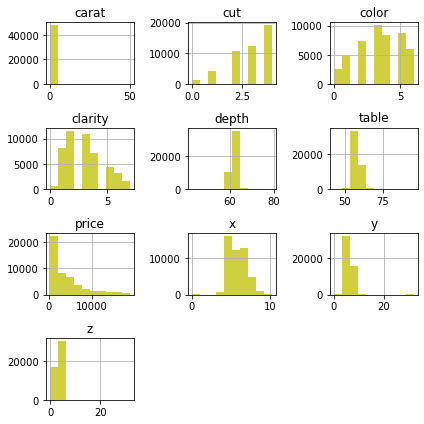

In [157]:
data.hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

As we can see from the histogram, there are some very large diamonds in this dataset. For all intents and purposes, nobody buys a diamond ring that is more than 5 carats (and that is absurd too), however, we are seeing diamonds as large as 50 carats. For our purposes, primarily to understand the diamond market for rings, we will remove those very large diamonds. Because they appear to be outliers, simply removing outliers should do the trick. 

##### Graph a boxplot to visualize outliers

<AxesSubplot:>

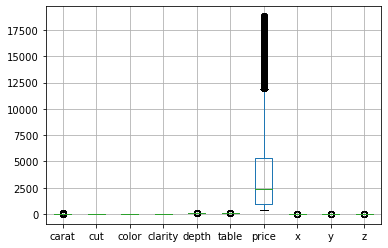

In [158]:
data.boxplot()

##### Eliminate outliers using a Standard Deviation model

We will eliminate outliers that are 3 standard deviations or more from the mean

<AxesSubplot:>

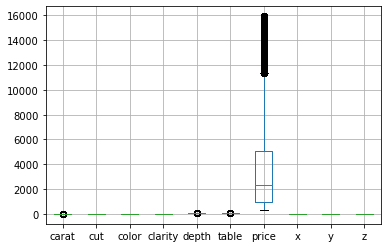

In [159]:
#Eliminate Outliers using a Standard Deviation model
for colName in data.columns:
    if data[colName].dtype == 'float64':
        mean = np.mean(data[colName])
        stdev = np.std(data[colName])
        cutoff = 3*stdev #using 3 standard deviations for outliers
        lower_range = mean - cutoff
        upper_range = mean + cutoff
        data = data[(data[colName] < upper_range) & (data[colName] > lower_range)]
        

#Graph a boxplot to visualize outliers 
data.boxplot()

##### New histogram of numerical values once outliers are removed

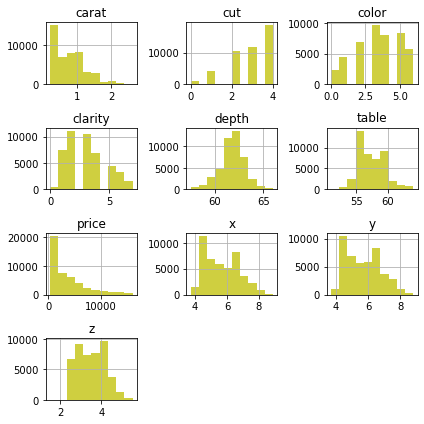

In [160]:
data.hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

There we go, much better. Now we have diamonds ranging up to 3 carats, which is typical for diamond rings. Let's move on, now, to our analysis of this sample. 

### 2.3: Diamond Shape Analysis

Now, one of the things missing in the dataset is the shape of the diamond. Diamonds can come in a variety of shapes, like the most common round or the elegantly sharp marquise. Although this dataset doesn't give the shape, it is correlated to the x-y dimensions of the diamond. For example, a round diamond, being a circle on top, will have a near 1:1 ratio of x to y, but the marquise may have closer to 2:1.

For this dataset, we will add in an x to y ratio value to explore estimates of shape and how much that may impact the price. We cannot perfectly guess the shape from the ratio, so we will keep the value as a ratio rather than converting it to a shape. 

##### Calculate the ratio and compare to other attributes

In [161]:
ratio = []
xy = pd.DataFrame(data, columns = ['x', 'y'])

i = 0

for value in xy.values:
    
    r = value[0]/value[1]
    ratio.append(r)

data['ratio'] = ratio

,carat,cut,color,clarity,depth,table,price,x,y,z,ratio
2105,0.70,3,4,2,62.6,55.0,2184.0,5.65,4.50,3.00,1.255556
4291,0.70,3,5,2,61.2,62.0,2396.0,6.65,5.73,3.48,1.160558
11545,1.12,3,2,4,61.6,58.0,6115.0,6.64,4.11,3.70,1.615572
14303,1.22,3,0,1,62.6,59.0,3156.0,6.79,4.24,3.76,1.601415
17671,1.51,0,2,3,65.6,56.0,7188.0,7.08,4.70,4.00,1.506383
34316,1.22,4,2,1,61.1,57.0,5703.0,6.90,5.92,4.22,1.165541
34799,0.70,3,2,2,62.0,61.0,2176.0,6.65,5.69,3.46,1.168717
42920,1.22,4,2,1,61.1,57.0,5807.0,6.90,5.92,4.22,1.165541


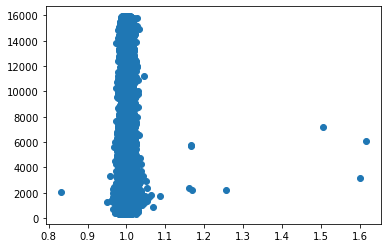

In [162]:
plt.scatter(data.ratio, data.price)
data[(data.ratio > 1.1)]

It appears that there is a very small range the ratio sits between. It's likely that they primarily use the round, or like-round, shapes in this dataset. Therefore, it won't be statistically significant and we will drop it from the data frame. 

##### Drop the ratio attribute from the data frame

In [163]:
data = data.drop(columns = ['ratio'])

## 3.0: Initial Exploration of the Data

### 3.1: Correlations

##### Determine the correlations of each numerical feature

In [164]:
corr = data.corr()
corr

,carat,cut,color,clarity,depth,table,price,x,y,z
carat,1.000000,-0.130352,-0.284250,-0.350028,0.025485,0.186475,0.923786,0.981210,0.980271,0.980259
cut,-0.130352,1.000000,0.015065,0.177141,-0.242679,-0.410920,-0.059525,-0.118126,-0.120304,-0.146153
color,-0.284250,0.015065,1.000000,-0.035561,-0.047477,-0.023599,-0.163972,-0.260655,-0.260542,-0.264705
clarity,-0.350028,0.177141,-0.035561,1.000000,-0.055641,-0.162029,-0.139618,-0.368944,-0.363852,-0.370802
depth,0.025485,-0.242679,-0.047477,-0.055641,1.000000,-0.281479,-0.002219,-0.024285,-0.026758,0.088109
table,0.186475,-0.410920,-0.023599,-0.162029,-0.281479,1.000000,0.132844,0.194348,0.189311,0.160309
price,0.923786,-0.059525,-0.163972,-0.139618,-0.002219,0.132844,1.000000,0.892452,0.893656,0.889490
x,0.981210,-0.118126,-0.260655,-0.368944,-0.024285,0.194348,0.892452,1.000000,0.998651,0.992710
y,0.980271,-0.120304,-0.260542,-0.363852,-0.026758,0.189311,0.893656,0.998651,1.000000,0.992349
z,0.980259,-0.146153,-0.264705,-0.370802,0.088109,0.160309,0.889490,0.992710,0.992349,1.000000


##### Draw a scatter matrix for the data

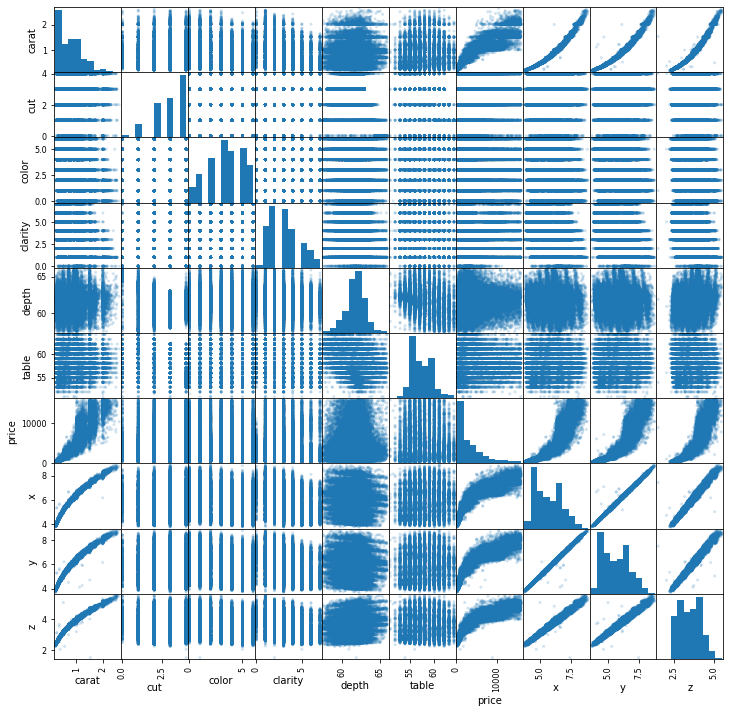

In [165]:
axes = scatter_matrix(data, alpha=0.2, figsize = (12, 12))

Price has the strongest correlation with carat and the x, y, and z dimensions. Carat also has a strong positive correlation with the x, y, and z dimnesions, likely because, as the weight of the diamond increases, so does the general size. The other 3 Cs, surprisingly, have weak negative correlations with price. This is a large surpise because as those features increase, the quality of the diamond increases. However, looking further into the data, there is a similar negative correlation between carat and color and carat and clarity. Our hypothesis is that since carat has a strong positive correlation to price, the negative correlation between carat and the other Cs is affecting the correlation between the Cs and price. Since we know, based upon how diamonds work, each C is independent of the other, this negative correlation is more of a measure of rarity in what jewlery shops store. The combination of cut, color, and clarity along with carat has more impact on price than the characteristics individually.     

As for the depth and table, they both have very weak correlation with any of the other features except for each other; which is a weak negative correlation.

Interestingly, there is a negative correlation between cut and both depth and table, meaning that as the cut improves, the depth and table decrease in size.  

### 3.2: Visualize the Data

##### Plot the Price by Carat, Cut, Clarity, and Color

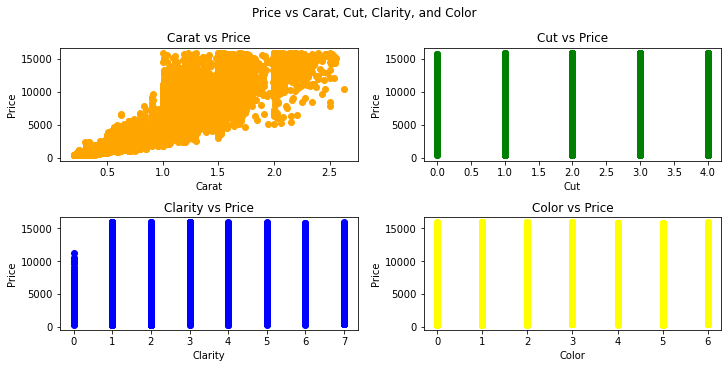

In [166]:
fig, ([plt1, plt2], [plt3, plt4]) = plt.subplots(2, 2, figsize = (10,5), constrained_layout = True)
fig.suptitle('Price vs Carat, Cut, Clarity, and Color')

# Carat vs Price
plt1.scatter(data.carat, data.price, c = 'orange')
plt1.set_xlabel('Carat', fontsize = 10)
plt1.set_ylabel('Price', fontsize = 10)
plt1.title.set_text('Carat vs Price')

# Cut vs Price
plt2.scatter(data.cut, data.price, c = 'green')
plt2.set_xlabel('Cut', fontsize = 10)
plt2.set_ylabel('Price', fontsize = 10)
plt2.title.set_text('Cut vs Price')

# Clarity vs Price
plt3.scatter(data.clarity, data.price, c = 'blue')
plt3.set_xlabel('Clarity', fontsize = 10)
plt3.set_ylabel('Price', fontsize = 10)
plt3.title.set_text('Clarity vs Price')

# Color vs Price
plt4.scatter(data.color, data.price, c = 'yellow')
plt4.set_xlabel('Color', fontsize = 10)
plt4.set_ylabel('Price', fontsize = 10)
plt4.title.set_text('Color vs Price')

plt.show()

From the scatter plots of price vs carat we notice that there is a relatively linear relationship. However, there is almost a box that forms with the upper limit at the 1 carat mark, where no matter the carat the diamond can be upwards of $15,000. On the lower boundary, however, there still remains a linear trend. 

For the other 3 Cs, there is almost no trend with price, which makes sense since from the correlation matrix.

The most outstanding trend, however, is the box in the carat and price graph. Our hypothesis is that up until 1 carat, the carat is the strongest factor in the price, but as it increases past 1 carat, the other Cs begin to more deeply influence the price. We will test this hypothesis later in the analysis.

In the meantime, we will perform various regression analyses, clustering, and classification.

## 4.0: Regression Analysis

### 4.1: Simple Linear Regression

Although we noticed the trend of a box forming after diamonds of around 1 carat. We will perform a simple linear regression on carat and price to set a baseline for the remaining analyses.

##### Build the linear regression model and measure its accuracy

In [167]:
X = np.array(data[['carat']].values)
y = np.array(data['price'])

pcmodel = LinearRegression()
simple_lin = pcmodel.fit(X,y)

print('Coefficient: ', simple_lin.coef_)
print('Y intercept: ', simple_lin.intercept_)

predictions = pcmodel.predict(X)
rmse = mean_squared_error(y, predictions, squared = False)
print('\n RMSE: ', rmse)

r2_lr = pcmodel.score(X, y)
print('\n R^2 Value: ', r2_lr)


Coefficient:  [7440.24011475]
Y intercept:  -2066.7904233047952

 RMSE:  1337.2367514352954

 R^2 Value:  0.8533806986374604


##### Plot the line determined by the regression over the scatter plot of carat and price

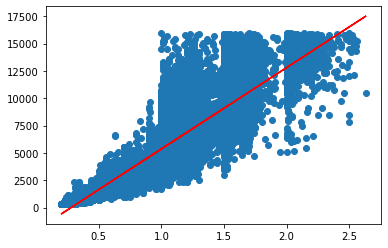

In [168]:
plt.scatter(data.carat, data.price)
plt.plot(data.carat, predictions, c = 'red')

### 4.2: Multiple Regression Analysis 

Taking a larger picture approach to predicting the price of a diamond, we will test 4 multiple regression algorithms to find the best model. These use all attributes to predict the price.  

##### Establish training data for predicting price via multiple algorithms

Since x, y, and z are highly correlated to carat, we will remove them from the data set to perform regression analysis. 

In [169]:
data = data.drop(columns = ['x', 'y', 'z'])
cols = data.drop(columns = 'price').columns
X = data.loc[:, data.columns != 'price']
y = np.array(data['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### 4.2.1: Model 1: Multiple Linear Regression

In [170]:
#For predicting price via Linear Regression
model = LinearRegression()
multi_lin = model.fit(X_train,y_train)

print('Coefficients are in the order: Carat, Cut, Color, Clarity, Depth, Table')
print('Coefficient: ', multi_lin.coef_)
print('Y intercept: ', multi_lin.intercept_)

predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared = False)
print('\n RMSE: ', rmse)

cross_val = cross_val_score(model, X_train, y_train)
print('\n Cross Validation Score: ')
print(list(zip(cols, cross_val)))

r2_lr = model.score(X_test, y_test)
print('\n R^2 Value: ', r2_lr)

Coefficients are in the order: Carat, Cut, Color, Clarity, Depth, Table
Coefficient:  [8451.58088419   94.24587682  289.83731848  478.36060449  -19.42893769
  -21.27233278]
Y intercept:  -3165.190844412608

 RMSE:  1051.294708978955

 Cross Validation Score: 
[('carat', 0.9137708331909509), ('cut', 0.9136803590665896), ('color', 0.9089115270935091), ('clarity', 0.9102479615871787), ('depth', 0.9073220037482018)]

 R^2 Value:  0.9117615381989929


#### 4.2.2: Model 2: Random Forest Regression 

In [171]:
#Predicting price via Random Forest Regression
rfrmodel = RandomForestRegressor()
rfrmodel.fit(X_train,y_train)

predictions_rf = rfrmodel.predict(X_test)
rmse_rf = mean_squared_error(y_test, predictions_rf, squared = False)
print('\n RMSE: ', rmse_rf)

cross_val = cross_val_score(rfrmodel, X_train, y_train)
print('\n Cross Validation Score: ')
print(list(zip(cols, cross_val)))

r2_rf = rfrmodel.score(X_test, y_test)
print('\n R^2 Value: ', r2_rf)


 RMSE:  474.9695726736006

 Cross Validation Score: 
[('carat', 0.9828358893352998), ('cut', 0.9808895510351799), ('color', 0.9808615274448713), ('clarity', 0.983048922816923), ('depth', 0.9814889415206184)]

 R^2 Value:  0.9819888870726894


#### 4.2.3: Model 3: K Nearest Neighbor Regression

In [172]:
#Predicting price via K Nearest Neighbor Regression
knnmodel = KNeighborsRegressor()
knnmodel.fit(X_train,y_train)

predictions = knnmodel.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared = False)
print('\n RMSE: ', rmse)

cross_val = cross_val_score(knnmodel, X_train, y_train)
print('\n Cross Validation Score: ')
print(list(zip(cols, cross_val)))

r2_knn = knnmodel.score(X_test, y_test)
print('\n R^2 Value: ', r2_knn)


 RMSE:  1691.255166365607

 Cross Validation Score: 
[('carat', 0.7583793450055805), ('cut', 0.7570525255738694), ('color', 0.7335140764333208), ('clarity', 0.7546775150991101), ('depth', 0.7435096341115223)]

 R^2 Value:  0.7716362090272506


#### 4.2.4: Model 4: Bayesian Ridge Regression

In [173]:
#Predicting the price with Bayesian Regression
brmodel = BayesianRidge()
brmodel.fit(X_train,y_train)

predictions = brmodel.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared = False)
print('\n RMSE: ', rmse)

cross_val = cross_val_score(brmodel, X_train, y_train)
print('\n Cross Validation Score: ')
print(list(zip(cols, cross_val)))

r2_br = brmodel.score(X_test, y_test)
print('\n R^2 Value: ', r2_br)


 RMSE:  1051.2944296516878

 Cross Validation Score: 
[('carat', 0.9137710324616847), ('cut', 0.9136803111663779), ('color', 0.9089118816366537), ('clarity', 0.9102474219400554), ('depth', 0.9073220634039714)]

 R^2 Value:  0.9117615850886136


#### 4.2.5: Comparison of the Regression Models

##### Graph the R-squared values for each model

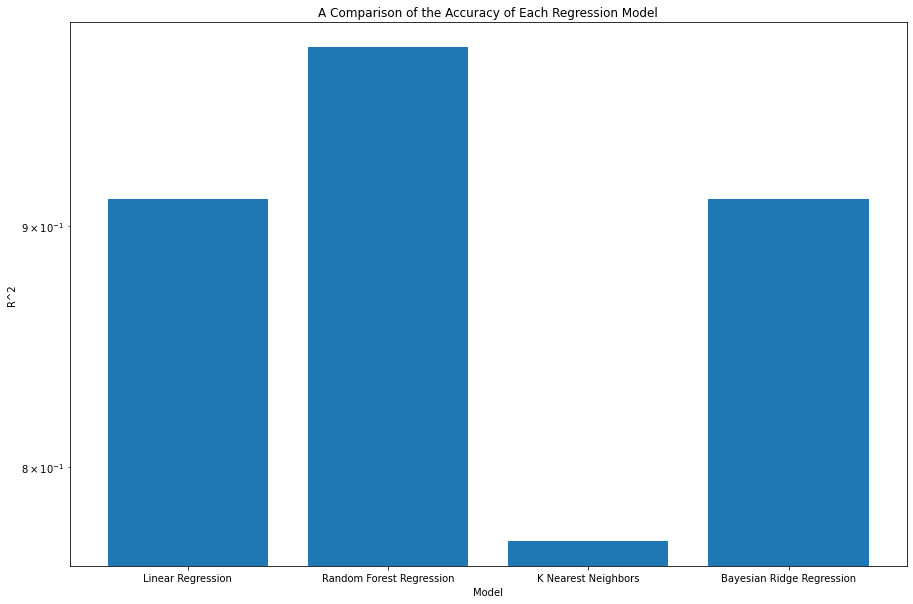

In [174]:
models = pd.DataFrame({'Model' : ['Linear Regression', 'Random Forest Regression', 'K Nearest Neighbors', 'Bayesian Ridge Regression'], 'Score' : [r2_lr, r2_rf, r2_knn, r2_br]})

fig = plt.figure(figsize=(15,10))
plt.bar(models.Model, models.Score, log = True)
plt.xlabel('Model')
plt.ylabel('R^2')
plt.title('A Comparison of the Accuracy of Each Regression Model')
plt.show()

For this dataset, both linear models (Linear Regression and Bayesian Ridge Regression) performed very similarily with r squared values of 0.91. The most accurate model was the Random Forest Regression with an r squared value of 0.98. The K Nearest Neighbor was the least accurate with an r squared value of 0.78. 

## 5.0: Clustering

Since the strongest correlation with price is Carat, we will perform cluster analysis on Carat and Price. For our clustering algorithm we will use two different algorithms: K Means and BIRCH.

##### Create a data frame with just carat and price

In [175]:
df = pd.DataFrame(data, columns = ['carat', 'price'])

### 5.1: K Means Clustering for Price and Carat

<function matplotlib.pyplot.show(close=None, block=None)>

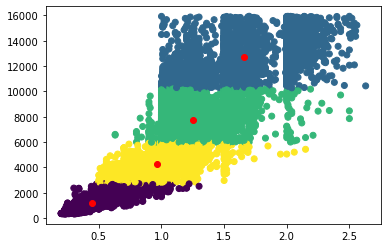

In [176]:
kmeans = KMeans(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_

plt.scatter(df['carat'],df['price'], c = kmeans.labels_.astype(float))
plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
plt.show

### 5.2: BIRCH Clustering for Price and Carat

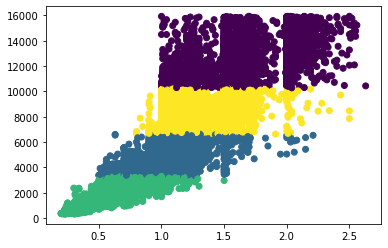

In [177]:
birch = Birch(threshold = 0.01, n_clusters = 4)
birch.fit(df)

prd = birch.predict(df)

plt.scatter(df['carat'], df['price'], c = prd)
plt.show()

The two different clustering algorithms do not have significant variation and can be used interchangeably.

## 6.0: Diamond Price Classification 

Now that we have some models for our data, let's classify each diamond's price level based upon its features. We will classify them on a scale of very cheap, cheap, average, over-priced, and very over-priced.

Because Random Forest Regression had the highest accuracy, we will classify the price based-upon that model. 

##### Classify each diamond

In [178]:
pclf = []
predictions_rf = rfrmodel.predict(X)
i = 0 

for value in y:
    if value > 2*(predictions_rf[i] + rmse_rf):
        pclf.append('Very Over-Priced')
        i += 1
        
    elif value > (predictions_rf[i] + rmse_rf):
        pclf.append('Over-Priced')
        i += 1
    elif value < (predictions_rf[i] - rmse_rf):
        pclf.append('Cheap')
        i += 1
    elif value < 2*(predictions_rf[i] - rmse_rf):
        pclf.append('Very Cheap')
        i += 1
    else:
        pclf.append('Average Price')
        i += 1

##### Make a data frame with the classification

In [179]:
class_data = data
class_data['deal'] = pclf
class_data.head()

,carat,cut,color,clarity,depth,table,price,deal
0,1.50,0,3,2,64.5,57.0,10352.0,Very Cheap
1,0.70,4,5,3,61.4,57.0,2274.0,Cheap
2,1.22,3,3,4,61.3,58.0,8779.0,Very Cheap
3,0.51,3,5,3,62.5,60.0,1590.0,Very Cheap
4,2.02,2,0,1,59.2,60.0,11757.0,Very Cheap


<AxesSubplot:>

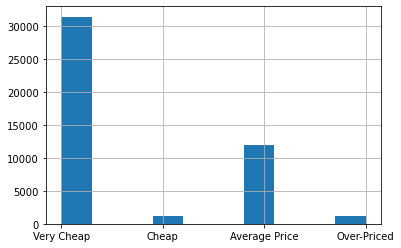

In [180]:
class_data['deal'].hist()

## 7.0: Diamonds Greater Than 1 Carat

For this exercise, we are primarily interested in the diamonds that are greater than 1 carat. We will start by recreating the simple linear regression model between carat and price.

##### Linear Regression on Carat and Price

Coefficient:  [7440.24011475]
Y intercept:  -2066.7904233047952

 RMSE:  1337.2367514352954

 R^2 Value:  0.8533806986374604


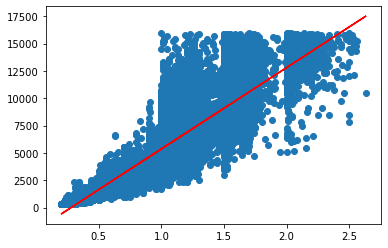

In [184]:
X = np.array(data[['carat']].values)
y = np.array(data['price'])

pcmodel = LinearRegression()
lin_reg = pcmodel.fit(X,y)
print('Coefficient: ', lin_reg.coef_)
print('Y intercept: ', lin_reg.intercept_)

predictions = pcmodel.predict(X)
rmse = mean_squared_error(y, predictions, squared = False)
print('\n RMSE: ', rmse)

r2_lr = pcmodel.score(X, y)
print('\n R^2 Value: ', r2_lr)

#Plot the line over the scatter plot of carat and price
plt.scatter(data.carat, data.price)
plt.plot(data.carat, predictions, c = 'red')


##### Select only the diamonds outside one standard error (RMSE) from the prediction and greater than 1 carat

We will split the diamonds into multiple regions: <br>
high_Ds: diamonds greater than 1 carat with price greater than 1 RMSE from the prediction <br>
low_Ds: diamonds greater than 1 carat with price less than 1 RMSE from the prediction <br>
middle_Ds: diamonds greater than 1 carat with price in between 1 RMSE higher than and lower than the prediction <br>
wierd_Ds: a combination of high_Ds and low_Ds <br>

In [186]:
over1_Ds = data[(data.carat > 1)]
high_Ds = data[(data.carat > 1) & (data.price > predictions + rmse)]
low_Ds = data[(data.carat > 1) & (data.price < predictions - rmse)]
middle_Ds = data[(data.carat > 1) & (data.price <= predictions + rmse) & (data.price >= predictions - rmse)]
wierd_Ds = data[(data.carat > 1) & ((data.price < predictions - rmse) | (data.price > predictions + rmse))]

##### Plot the different regions: high, middle, and low

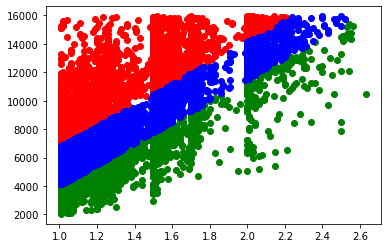

In [187]:
plt.scatter(high_Ds.carat, high_Ds.price, c = 'red')
plt.scatter(low_Ds.carat, low_Ds.price, c = 'green')
plt.scatter(middle_Ds.carat, middle_Ds.price, c = 'blue')

##### Find the correlations among the attributes for only the diamonds greater than 1 carat

In [189]:
over1_Ds.corr()

,carat,cut,color,clarity,depth,table,price
carat,1.000000,-0.040444,-0.301343,-0.142883,0.010215,0.078511,0.747460
cut,-0.040444,1.000000,-0.029708,0.130435,-0.274181,-0.375905,0.087412
color,-0.301343,-0.029708,1.000000,-0.008328,-0.027987,-0.005409,0.040355
clarity,-0.142883,0.130435,-0.008328,1.000000,-0.043674,-0.111127,0.348440
depth,0.010215,-0.274181,-0.027987,-0.043674,1.000000,-0.263531,-0.044355
table,0.078511,-0.375905,-0.005409,-0.111127,-0.263531,1.000000,-0.027388
price,0.747460,0.087412,0.040355,0.348440,-0.044355,-0.027388,1.000000


As we can see from the above correlation chart, with diamonds over 1 carat the clarity now has a significantly higher correlation with price than it did for diamonds under 1 carat. Likewise, carat has a reduced correlation as well. However, color and cut still don't have strong correlations. This may simply be the pattern for diamonds following the linear regression line for carat v.s price. If we look at the values outside of the typical boundaries of that regression line, there may be a different story.  

##### Find the correlations for diamonds outside the typical error of the linear regression line between carat and price

In [190]:
wierd_Ds.corr()

,carat,cut,color,clarity,depth,table,price
carat,1.000000,-0.076978,-0.207572,-0.183877,0.027967,0.087193,0.623654
cut,-0.076978,1.000000,0.048409,0.216535,-0.317037,-0.363090,0.144521
color,-0.207572,0.048409,1.000000,0.222221,-0.057899,-0.052109,0.288979
clarity,-0.183877,0.216535,0.222221,1.000000,-0.080239,-0.164690,0.477248
depth,0.027967,-0.317037,-0.057899,-0.080239,1.000000,-0.263163,-0.067422
table,0.087193,-0.363090,-0.052109,-0.164690,-0.263163,1.000000,-0.078978
price,0.623654,0.144521,0.288979,0.477248,-0.067422,-0.078978,1.000000


As our hypothesis predicted, there is a much stronger positive correlation between the other Cs and the price. As a result, the carat has a slightly reduced positive correlation with price, although it is still the strongest. 

In order of the strongest to weakest correlation for the 4 Cs with price we have carat, clarity, color and cut.

##### Compare the number of diamonds that follow the trend to those that do not

In [193]:
size_wierd = len(wierd_Ds)
size_trend = len(middle_Ds)

print('Number of diamonds that do not follow the trend: ', size_wierd)
print('Number of diamonds that follow the trend: ', size_trend)
print('Percent that do not follow the trend: ', size_wierd/(size_wierd + size_trend))

Number of diamonds that do not follow the trend:  7161
Number of diamonds that follow the trend:  6979
Percent that do not follow the trend:  0.5064356435643564


Essentially, there are many diamonds that follow a general linear trend between carat and price with a relatively small overall price influence based on the other Cs. However, with diamonds greater than 1 carat, there is an influx of diamonds that now have their price influenced by the other Cs. Some still follow the trend, but a little over 50% of diamonds over 1 carat have their price strongly influenced by the other Cs.

Diving deeper, we may be able to capture more information from looking at the general descriptive analytics of each section.

##### Descriptive analytics of all diamonds over 1 carat

In [194]:
over1_Ds.describe()

,carat,cut,color,clarity,depth,table,price
count,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000
mean,1.297036,2.856577,2.804314,2.478996,61.761075,57.785028,7770.420368
std,0.308421,1.049761,1.700537,1.441329,1.357211,2.017095,3249.912469
min,1.010000,0.000000,0.000000,0.000000,57.500000,51.000000,2036.000000
25%,1.040000,2.000000,2.000000,1.000000,61.000000,56.000000,5124.000000
50%,1.200000,3.000000,3.000000,2.000000,61.900000,58.000000,6837.000000
75%,1.510000,4.000000,4.000000,3.000000,62.600000,59.000000,9959.000000
max,2.630000,4.000000,6.000000,7.000000,66.000000,64.000000,15937.000000


##### Descriptive analytics of the diamonds in the high_Ds group

In [195]:
high_Ds.describe()

,carat,cut,color,clarity,depth,table,price
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000
mean,1.360812,3.085198,3.617147,3.791318,61.642303,57.459477,11167.878943
std,0.296669,0.964454,1.348853,1.429245,1.192567,1.914095,2585.625696
min,1.010000,0.000000,0.000000,1.000000,57.700000,51.000000,6787.000000
25%,1.090000,2.000000,3.000000,3.000000,61.000000,56.000000,8912.000000
50%,1.290000,3.000000,4.000000,4.000000,61.800000,57.000000,11113.000000
75%,1.530000,4.000000,5.000000,5.000000,62.400000,59.000000,13214.000000
max,2.210000,4.000000,6.000000,7.000000,66.000000,64.000000,15937.000000


##### Descriptive analytics of the diamonds in the low_Ds group

In [196]:
low_Ds.describe()

,carat,cut,color,clarity,depth,table,price
count,3452.000000,3452.000000,3452.000000,3452.000000,3452.000000,3452.000000,3452.000000
mean,1.295826,2.609502,1.852839,1.416570,61.914455,58.113847,5434.800406
std,0.297090,1.119052,1.657700,0.935313,1.545949,2.090851,2033.748707
min,1.010000,0.000000,0.000000,0.000000,57.500000,52.000000,2036.000000
25%,1.090000,2.000000,0.000000,1.000000,61.075000,57.000000,4078.000000
50%,1.200000,3.000000,2.000000,1.000000,62.000000,58.000000,4844.000000
75%,1.500000,3.000000,3.000000,2.000000,62.800000,59.000000,6149.250000
max,2.630000,4.000000,6.000000,6.000000,66.000000,64.000000,15394.000000


What we see from looking at these charts is that the mean of the other 3 C's in the higher range are higher than the total mean, and vice versa for the lower range. This aligns with what we assumed from the correlation matrix, but gives more granularity for what values to expect in those price ranges.